## 獲取Spotify auth_token

In [132]:
import re
import urllib.parse
import requests
import base64
import pandas as pd
from datetime import datetime

pd.set_option('display.max_columns', None)


def get_auth_url(client_id, redirect_uri):
    scope = 'user-read-private user-read-email user-top-read user-library-read'
    
    auth_url_params = {
        'client_id': client_id,
        'response_type': 'code',
        'scope': scope,
        'redirect_uri': redirect_uri,
        'show_dialog': 'true'
    }

    auth_url = f'https://accounts.spotify.com/authorize?{urllib.parse.urlencode(auth_url_params)}'
    
    return f'請訪問此URL以授權應用程式：{auth_url}'

def exchange_code_for_tokens(auth_code, client_id, client_secret, redirect_uri):
    credentials = f"{client_id}:{client_secret}"
    encoded_credentials = base64.b64encode(credentials.encode()).decode()

    token_url = 'https://accounts.spotify.com/api/token'
    token_data = {
        'grant_type': 'authorization_code',
        'code': auth_code,
        'redirect_uri': redirect_uri
    }
    token_headers = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }

    response = requests.post(token_url, headers=token_headers, data=token_data)
    if response.status_code == 200:
        tokens = response.json()
        return tokens
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

def refresh_access_token(refresh_token, client_id, client_secret):
    credentials = f"{client_id}:{client_secret}"
    encoded_credentials = base64.b64encode(credentials.encode()).decode()

    token_url = 'https://accounts.spotify.com/api/token'
    token_data = {
        'grant_type': 'refresh_token',
        'refresh_token': refresh_token
    }
    token_headers = {
        'Authorization': f'Basic {encoded_credentials}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }

    response = requests.post(token_url, headers=token_headers, data=token_data)
    if response.status_code == 200:
        tokens = response.json()
        return tokens['access_token']
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [133]:
client_id = ''
client_secret = ''
redirect_uri = ''

# 第一次先手動獲取auth_code
auth_url = get_auth_url(client_id, redirect_uri)
auth_url

'請訪問此URL以授權應用程式：'

In [134]:
url = 'https://github.com/SamHuang1018?code=AQAwsnbGbdd2SeC3aTZOkZQ-BCPsukVBMt321_qQP1QHrs2m-z117VsAqZOvHwJ0F0rbqPAvZIE5I3hNwow08PqVMEgim4AXBPBs4EoaCyqZAuIrZlfKxL3nuBNhcGg3XE0URqko4_8oPzVBYC0pvDqYGA8pfKzqwUDbl_dhBp-WfCVy6vZLTp-KmQdVK5kiWc9UEhRqHdx9wia9RSWKt9EbcyyA-E9X2_K6i450_ehvrlJo5B1KLg0xksfRw-K8uX5BUBuOYhDG'
match = re.search(r'code=([\w-]+)', url)
auth_code = match.group(1)

tokens = exchange_code_for_tokens(auth_code, client_id, client_secret, redirect_uri)
session = {'access_token': tokens['access_token'], 'expires_at': datetime.now().timestamp() + tokens['expires_in'], 'refresh_token': tokens['refresh_token']}
access_token = refresh_access_token(session['refresh_token'], client_id, client_secret)

## Spotify API

#### 串接起始值

In [135]:
def spotify_request(endpoint):
    global access_token
    if datetime.now() > datetime.fromtimestamp(session['expires_at']):
        refresh_access_token()
    
    headers = {'Authorization': f'Bearer {access_token}'}
    
    data = []
    limit = 50
    offset = 0
    total_tracks = requests.get('https://api.spotify.com/v1/' + endpoint + f'?limit={limit}&offset={offset}', headers=headers).json()['total']

    for offset in range(0, total_tracks, limit):
        url = 'https://api.spotify.com/v1/' + endpoint + f'?limit={limit}&offset={offset}'
        # print(url)
        response = requests.get(url, headers=headers).json()
        data.extend(response['items'])
    
    return data

In [136]:
playlists = spotify_request('playlists/2YcZP6aa6osb8XSdIGyJUm/tracks')
top_artists = spotify_request('me/top/artists')
top_tracks = spotify_request('me/top/tracks')
print(f'總共曲目: {len(playlists)}')
print(f'總共熱門藝人: {len(top_artists)}')
print(f'總共熱門專輯: {len(top_tracks)}')

總共曲目: 642
總共熱門藝人: 114
總共熱門專輯: 1343


#### 播放清單

In [137]:
columns = [
    'added_at', 'added_by', 'is_local', 'primary_color', 'track_preview_url',
    'track_available_markets', 'explicit', 'track_type', 'episode', 
    'album_available_markets', 'album_type',  'album_href',
    'album_id', 'album_image_url', 'album_name', 'album_release_date',
    'album_release_date_precision', 'album_uri', 'album_artists',
    'album_external_urls', 'album_total_tracks', 'artists', 'disc_number',
    'track_number', 'duration_ms', 'external_ids_isrc', 'external_urls_spotify',
    'track_href', 'track_id', 'track_name', 'track_popularity', 'track_uri',
    'video_thumbnail_url'
]
playlists_df = pd.DataFrame(columns=columns)

def extract_track_info(track_item):
    track = track_item.get('track', {})
    album = track.get('album', {})
    
    return {
        'added_at': track_item.get('added_at'),
        'added_by': track_item.get('added_by', {}).get('id'),
        'is_local': track_item.get('is_local'),
        'primary_color': track_item.get('primary_color'),
        'track_preview_url': track.get('preview_url'),
        'track_available_markets': track.get('available_markets'),
        'explicit': track.get('explicit'),
        'track_type': track.get('type'),
        'episode': track.get('episode'),
        'album_available_markets': album.get('available_markets'),
        'album_type': album.get('album_type'),
        'album_href': album.get('href'),
        'album_id': album.get('id'),
        'album_image_url': album.get('images', [{}])[0].get('url') if album.get('images') else None,
        'album_name': album.get('name'),
        'album_release_date': album.get('release_date'),
        'album_release_date_precision': album.get('release_date_precision'),
        'album_uri': album.get('uri'),
        'album_artists': [artist['name'] for artist in album.get('artists', [])],
        'album_external_urls': album.get('external_urls', {}).get('spotify'),
        'album_total_tracks': album.get('total_tracks'),
        'artists': [artist['name'] for artist in track.get('artists', [])],
        'disc_number': track.get('disc_number'),
        'track_number': track.get('track_number'),
        'duration_ms': track.get('duration_ms'),
        'external_ids_isrc': track.get('external_ids', {}).get('isrc'),
        'external_urls_spotify': track.get('external_urls', {}).get('spotify'),
        'track_href': track.get('href'),
        'track_id': track.get('id'),
        'track_name': track.get('name'),
        'track_popularity': track.get('popularity'),
        'track_uri': track.get('uri'),
        'video_thumbnail_url': track_item.get('video_thumbnail', {}).get('url')
    }

playlist_data = [extract_track_info(track_item) for track_item in playlists]
playlists_df = pd.DataFrame(playlist_data, columns=columns)
playlists_df['duration_ms'] = pd.to_timedelta(playlists_df['duration_ms'], unit='ms').apply(lambda x: f"{x.components.minutes}m {x.components.seconds}s")

display(playlists_df)

,added_at,added_by,is_local,primary_color,track_preview_url,track_available_markets,explicit,track_type,episode,album_available_markets,album_type,album_href,album_id,album_image_url,album_name,album_release_date,album_release_date_precision,album_uri,album_artists,album_external_urls,album_total_tracks,artists,disc_number,track_number,duration_ms,external_ids_isrc,external_urls_spotify,track_href,track_id,track_name,track_popularity,track_uri,video_thumbnail_url
0,2022-07-28T15:41:21Z,11124654085,False,None,https://p.scdn.co/mp3-preview/22eb68cc3789f115...,[],False,track,False,[],single,https://api.spotify.com/v1/albums/32VfvVGwzuka...,32VfvVGwzuka6xQSrdyamD,https://i.scdn.co/image/ab67616d0000b273eb62b8...,スーパーハイパー忍者手裏剣,2022-07-13,day,spotify:album:32VfvVGwzuka6xQSrdyamD,[peanut butters],https://open.spotify.com/album/32VfvVGwzuka6xQ...,1,[peanut butters],1,1,3m 29s,JPB452205993,https://open.spotify.com/track/5xqxfPEKE3K7Su3...,https://api.spotify.com/v1/tracks/5xqxfPEKE3K7...,5xqxfPEKE3K7Su32bnKtrQ,スーパーハイパー忍者手裏剣,0,spotify:track:5xqxfPEKE3K7Su32bnKtrQ,None
1,2022-07-29T02:28:48Z,11124654085,False,None,https://p.scdn.co/mp3-preview/82a8c178625c7776...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",False,track,False,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",album,https://api.spotify.com/v1/albums/0kVzT55moiHL...,0kVzT55moiHLN4Yr3rDGRw,https://i.scdn.co/image/ab67616d0000b273fbffbf...,方向感,2006,year,spotify:album:0kVzT55moiHLN4Yr3rDGRw,[1976],https://open.spotify.com/album/0kVzT55moiHLN4Y...,12,[1976],1,5,5m 57s,TWA470076005,https://open.spotify.com/track/7fopK1NBhSZnRz0...,https://api.spotify.com/v1/tracks/7fopK1NBhSZn...,7fopK1NBhSZnRz0YqDcKry,方向感,27,spotify:track:7fopK1NBhSZnRz0YqDcKry,None
2,2022-07-29T02:28:55Z,11124654085,False,None,https://p.scdn.co/mp3-preview/6d2440374a5a7d2a...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",False,track,False,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",album,https://api.spotify.com/v1/albums/42VABZoODED0...,42VABZoODED0S2Ne4zLCUc,https://i.scdn.co/image/ab67616d0000b2735b972f...,NEO-N,2019-10-09,day,spotify:album:42VABZoODED0S2Ne4zLCUc,[AIRFLIP],https://open.spotify.com/album/42VABZoODED0S2N...,11,[AIRFLIP],1,2,3m 53s,JPCO01918630,https://open.spotify.com/track/6vEMm79EkT35v5U...,https://api.spotify.com/v1/tracks/6vEMm79EkT35...,6vEMm79EkT35v5UGJbbZ03,Meaning,22,spotify:track:6vEMm79EkT35v5UGJbbZ03,None
3,2022-07-29T02:29:05Z,11124654085,False,None,https://p.scdn.co/mp3-preview/5262679961609398...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",False,track,False,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",album,https://api.spotify.com/v1/albums/052EiTRYh35M...,052EiTRYh35MuDVJN9Emdh,https://i.scdn.co/image/ab67616d0000b273775e81...,STRAY SHEEP,2020-08-05,day,spotify:album:052EiTRYh35MuDVJN9Emdh,[Kenshi Yonezu],https://open.spotify.com/album/052EiTRYh35MuDV...,15,[Kenshi Yonezu],1,8,4m 15s,JPU901800227,https://open.spotify.com/track/04TshWXkhV1qkqH...,https://api.spotify.com/v1/tracks/04TshWXkhV1q...,04TshWXkhV1qkqHzf31Hn6,Lemon,69,spotify:track:04TshWXkhV1qkqHzf31Hn6,None
4,2022-07-29T02:29:12Z,11124654085,False,None,https://p.scdn.co/mp3-preview/743e653c838a411c...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",False,track,False,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",album,https://api.spotify.com/v1/albums/4tg1ZCJOqMRJ...,4tg1ZCJOqMRJAnGT9WdWV7,https://i.scdn.co/image/ab67616d0000b273510baa...,歹勢好勢,2021-04-30,day,spotify:album:4tg1ZCJOqMRJAnGT9WdWV7,[Sorry Youth],https://open.spotify.com/album/4tg1ZCJOqMRJAnG...,9,[Sorry Youth],1,5,5m 6s,TWIJ52100005,https://open.spotify.com/track/0ZDCK73eJC4Uyv2...,https://api.spotify.com/v1/tracks/0ZDCK73eJC4U...,0ZDCK73eJC4Uyv2XjGv1YP,歹勢中年,38,spotify:track:0ZDCK73eJC4Uyv2XjGv1YP,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2024-03-31T04:19:47Z,11124654085,False,None,https://p.scdn.co/mp3-previe

#### 熱門藝人

In [138]:
columns = ['external_urls', 'followers', 'genres', 'href', 'id', 'images', 'name', 'popularity', 'type', 'uri']
top_artists_df = pd.DataFrame(columns=columns)

def extract_artist_info(artist_item):
    return {
        'external_urls': artist_item.get('external_urls', {}).get('spotify'),
        'followers': artist_item.get('followers', {}).get('total'),
        'genres': ', '.join(artist_item.get('genres', [])),
        'href': artist_item.get('href'),
        'id': artist_item.get('id'),
        'images': ', '.join([img['url'] for img in artist_item.get('images', [])]),
        'name': artist_item.get('name'),
        'popularity': artist_item.get('popularity'),
        'type': artist_item.get('type'),
        'uri': artist_item.get('uri')
    }
    
playlist_data = [extract_artist_info(artist_item) for artist_item in top_artists]
top_artists_df = pd.DataFrame(playlist_data, columns=columns)
display(top_artists_df)

,external_urls,followers,genres,href,id,images,name,popularity,type,uri
0,https://open.spotify.com/artist/7qBIgabdHdcr6N...,105180,"mandopop, taiwan indie, taiwan pop, taiwan punk",https://api.spotify.com/v1/artists/7qBIgabdHdc...,7qBIgabdHdcr6NLujDxWAU,https://i.scdn.co/image/ab6761610000e5eb6a16f9...,Fire EX.,44,artist,spotify:artist:7qBIgabdHdcr6NLujDxWAU
1,https://open.spotify.com/artist/2elBjNSdBE2Y3f...,5565465,"c-pop, mandopop, taiwan pop, zhongguo feng",https://api.spotify.com/v1/artists/2elBjNSdBE2...,2elBjNSdBE2Y3f0j1mjrql,https://i.scdn.co/image/ab6761610000e5eb02b3aa...,Jay Chou,69,artist,spotify:artist:2elBjNSdBE2Y3f0j1mjrql
2,https://open.spotify.com/artist/3PTsVPijj4pjIo...,83607,"chinese electropop, mandopop, taiwan indie, ta...",https://api.spotify.com/v1/artists/3PTsVPijj4p...,3PTsVPijj4pjIol9yML0rK,https://i.scdn.co/image/ab6761610000e5eb8a224a...,Astro Bunny,37,artist,spotify:artist:3PTsVPijj4pjIol9yML0rK
3,https://open.spotify.com/artist/6c4IBMTcnFDhsK...,46196,"taiwan indie, taiwan pop, taiwan punk, taiwane...",https://api.spotify.com/v1/artists/6c4IBMTcnFD...,6c4IBMTcnFDhsKHXNSBBvp,https://i.scdn.co/image/ab6761610000e5eb2f1c8d...,Sorry Youth,35,artist,spotify:artist:6c4IBMTcnFDhsKHXNSBBvp
4,https://open.spotify.com/artist/5XuYYh7VssmjmE...,3991,"taiwan indie, taiwan punk",https://api.spotify.com/v1/artists/5XuYYh7Vssm...,5XuYYh7VssmjmETxEBUF2M,https://i.scdn.co/image/ab6761610000e5eb2cb915...,EmptyORio,14,artist,spotify:artist:5XuYYh7VssmjmETxEBUF2M
...,...,...,...,...,...,...,...,...,...,...
109,https://open.spotify.com/artist/6rT3tJQmePSMr6...,566,,https://api.spotify.com/v1/artists/6rT3tJQmePS...,6rT3tJQmePSMr68mPaqyyp,https://i.scdn.co/image/ab6761610000e5eb2c6b88...,Garden Collective,43,artist,spotify:artist:6rT3tJQmePSMr68mPaqyyp
110,https://open.spotify.com/artist/7EqcX6VMuJAQVi...,404,,https://api.spotify.com/v1/artists/7EqcX6VMuJA...,7EqcX6VMuJAQViJqJrL2yA,https://i.scdn.co/image/ab6761610000e5ebc1d07e...,Hers Lake,44,artist,spotify:artist:7EqcX6VMuJAQViJqJrL2yA
111,https://open.spotify.com/artist/7qmOAgRUFZhLfw...,416,,https://api.spotify.com/v1/artists/7qmOAgRUFZh...,7qmOAgRUFZhLfwtyCGPKdo,https://i.scdn.co/image/ab6761610000e5eb3182fe...,Isaak Young,43,artist,spotify:artist:7qmOAgRUFZhLfwtyCGPKdo
112,https://open.spotify.com/artist/4TcOznbEZBqev2...,388555,"mandopop, taiwan pop",https://api.spotify.com/v1/artists/4TcOznbEZBq...,4TcOznbEZBqev21LzAH4KE,https://i.scdn.co/image/ab6761610000e5eb4d8331...,高爾宣 OSN,54,artist,spotify:artist:4TcOznbEZBqev21LzAH4KE


#### 熱門曲目

In [139]:
columns = [
    'album_type', 'artists_href', 'artists_id', 'artists_name', 'artists_type', 'artists_uri', 'artists_available_markets',
    'album_href', 'album_id', 'album_image', 'album_name', 'release_date', 'release_date_precision', 'total_tracks', 'album_uri',
    'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'track_href', 'track_id', 'track_is_local', 'track_name',
    'popularity', '30_seconds_music', 'track_type', 'track_uri'
    ]
top_tracks_df = pd.DataFrame(columns=columns)

def extract_track_info(track_item):
    album = track_item['album']
    artists = track_item['artists']
    first_artist = artists[0] if artists else {}
    
    return {
        'album_type': album.get('album_type', ''),
        'artists_href': first_artist.get('href', ''),
        'artists_id': first_artist.get('id', ''),
        'artists_name': first_artist.get('name', ''),
        'artists_type': first_artist.get('type', ''),
        'artists_uri': first_artist.get('uri', ''),
        'artists_available_markets': album.get('available_markets', []),
        'album_href': album.get('href', ''),
        'album_id': album.get('id', ''),
        'album_image': album['images'][0]['url'] if album.get('images') else '',
        'album_name': album.get('name', ''),
        'release_date': album.get('release_date', ''),
        'release_date_precision': album.get('release_date_precision', ''),
        'total_tracks': album.get('total_tracks', 0),
        'album_uri': album.get('uri', ''),
        'album_available_markets': track_item.get('available_markets', []),
        'disc_number': track_item.get('disc_number', 0),
        'duration_ms': track_item.get('duration_ms', 0),
        'explicit': track_item.get('explicit', False),
        'external_ids': track_item['external_ids'].get('isrc', '') if track_item.get('external_ids') else '',
        'track_href': track_item.get('href', ''),
        'track_id': track_item.get('id', ''),
        'track_is_local': track_item.get('is_local', False),
        'track_name': track_item.get('name', ''),
        'popularity': track_item.get('popularity', 0),
        '30_seconds_music': track_item.get('preview_url', ''),
        'track_type': track_item.get('type', ''),
        'track_uri': track_item.get('uri', '')
    }
    
extracted_data = [extract_track_info(track) for track in top_tracks]
top_tracks_df = pd.DataFrame(extracted_data)
top_tracks_df['duration_ms'] = pd.to_timedelta(top_tracks_df['duration_ms'], unit='ms').apply(lambda x: f"{x.components.minutes}m {x.components.seconds}s")

display(top_tracks_df)

,album_type,artists_href,artists_id,artists_name,artists_type,artists_uri,artists_available_markets,album_href,album_id,album_image,album_name,release_date,release_date_precision,total_tracks,album_uri,album_available_markets,disc_number,duration_ms,explicit,external_ids,track_href,track_id,track_is_local,track_name,popularity,30_seconds_music,track_type,track_uri
0,ALBUM,https://api.spotify.com/v1/artists/7qBIgabdHdc...,7qBIgabdHdcr6NLujDxWAU,Fire EX.,artist,spotify:artist:7qBIgabdHdcr6NLujDxWAU,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",https://api.spotify.com/v1/albums/2PkESw7qmj3V...,2PkESw7qmj3Vc4X2R4KSPy,https://i.scdn.co/image/ab67616d0000b2739ddf8d...,進擊下半場,2017-04-14,day,21,spotify:album:2PkESw7qmj3Vc4X2R4KSPy,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,3m 6s,False,TWBF31704020,https://api.spotify.com/v1/tracks/2DZLyqxPBCzi...,2DZLyqxPBCziw1YJOWPCjQ,False,長途夜車,52,https://p.scdn.co/mp3-preview/60c3733785fded9f...,track,spotify:track:2DZLyqxPBCziw1YJOWPCjQ
1,ALBUM,https://api.spotify.com/v1/artists/7qBIgabdHdc...,7qBIgabdHdcr6NLujDxWAU,Fire EX.,artist,spotify:artist:7qBIgabdHdcr6NLujDxWAU,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",https://api.spotify.com/v1/albums/085Z2SYvqoao...,085Z2SYvqoao1GwcdidsS7,https://i.scdn.co/image/ab67616d0000b2734f55ec...,Reborn,2016-03-25,day,12,spotify:album:085Z2SYvqoao1GwcdidsS7,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,4m 9s,False,TWBF31603009,https://api.spotify.com/v1/tracks/5DtVMfHHv0gH...,5DtVMfHHv0gHgwOtPoxMcT,False,繼續向前行,32,https://p.scdn.co/mp3-preview/63d985bd90be04b8...,track,spotify:track:5DtVMfHHv0gHgwOtPoxMcT
2,ALBUM,https://api.spotify.com/v1/artists/3Xp3DA50zRP...,3Xp3DA50zRP4TYOtNR7k1T,Soft Lipa,artist,spotify:artist:3Xp3DA50zRP4TYOtNR7k1T,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",https://api.spotify.com/v1/albums/4yw85NDJ9SkY...,4yw85NDJ9SkYVMxBOwqx4Z,https://i.scdn.co/image/ab67616d0000b273002a90...,收斂水,2009-07-22,day,14,spotify:album:4yw85NDJ9SkYVMxBOwqx4Z,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,5m 16s,True,TWI450900005,https://api.spotify.com/v1/tracks/13tJ9Mkj7cjX...,13tJ9Mkj7cjXxrTjOh0LAN,False,關於小熊,50,https://p.scdn.co/mp3-preview/77ce0222c53af326...,track,spotify:track:13tJ9Mkj7cjXxrTjOh0LAN
3,SINGLE,https://api.spotify.com/v1/artists/3PTsVPijj4p...,3PTsVPijj4pjIol9yML0rK,Astro Bunny,artist,spotify:artist:3PTsVPijj4pjIol9yML0rK,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",https://api.spotify.com/v1/albums/1FvL5S6imtz7...,1FvL5S6imtz7bYXjdOlWgv,https://i.scdn.co/image/ab67616d0000b273f9ec23...,你已忘記但我還記得的事,2020-11-25,day,1,spotify:album:1FvL5S6imtz7bYXjdOlWgv,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,3m 51s,False,TWA452000058,https://api.spotify.com/v1/tracks/1Et2Gm6vcU79...,1Et2Gm6vcU79f2nBndPmno,False,你已忘記但我還記得的事,20,https://p.scdn.co/mp3-preview/ede1b682d01e8ddb...,track,spotify:track:1Et2Gm6vcU79f2nBndPmno
4,ALBUM,https://api.spotify.com/v1/artists/6FGSUph2Uv0...,6FGSUph2Uv0yi2oM1hDV78,I Mean Us,artist,spotify:artist:6FGSUph2Uv0yi2oM1hDV78,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",https://api.spotify.com/v1/albums/5azoxbgGTCqw...,5azoxbgGTCqwqgpiirrctu,https://i.scdn.co/image/ab67616d0000b27351b586...,OST,2018-08-24,day,8,spotify:album:5azoxbgGTCqwqgpiirrctu,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,5m 25s,False,TWP011840607,https://api.spotify.com/v1/tracks/6desVkqsKDt0...,6desVkqsKDt0ZHLqPcWcbZ,False,You So (Youth Soul),33,https://p.scdn.co/mp3-preview/dd23af707a3fdc83...,track,spotify:track:6desVkqsKDt0ZHLqPcWcbZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,ALBUM,https://api.spotify.com/v1/artists/6ft7JnxMyZh...,6ft7JnxMyZhp7N52qzHymY,Vansire,artist,spotify:artist:6ft7JnxMyZhp7N52qzHymY,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",https://api.spotify.com/v1/albums/7CESHttY9U97...,7CESHttY9U97FElD5JAXSW,https://i.scdn.co/image/ab67616d0000b273a78876...,Angel Youth,2018-04-26,

#### 獲取歌曲特色

In [140]:
def extract_track_feature_info(id):
    global access_token
    if datetime.now() > datetime.fromtimestamp(session['expires_at']):
        refresh_access_token()
    
    headers = {'Authorization': f'Bearer {access_token}'}
    
    response = requests.get(f'https://api.spotify.com/v1/audio-features/{id}', headers=headers).json()

    
    return response  

tracks_feature = []
for i in range(len(playlists_df['track_id'])):
    tracks_feature.append(extract_track_feature_info(playlists_df['track_id'][i]))

In [141]:
tracks_feature_df = pd.DataFrame(tracks_feature).drop(columns={'type', 'uri', 'duration_ms'})
filter_top_tracks_df = playlists_df[[
                                    'added_at', 'added_by', 'track_preview_url', 'track_available_markets', 'explicit',
                                    'album_available_markets',  'album_type', 'album_href', 'album_id', 'album_image_url', 'album_name',
                                    'album_release_date', 'album_release_date_precision', 'album_uri', 'album_artists', 'album_external_urls',
                                    'album_total_tracks', 'artists', 'disc_number', 'track_number', 'duration_ms', 'external_ids_isrc',
                                    'external_urls_spotify', 'track_id', 'track_name', 'track_popularity', 'track_uri'
                                ]].rename(columns={'track_id': 'id'})
total_feature_info_df = pd.merge(tracks_feature_df, filter_top_tracks_df, on='id', how='inner')

In [142]:
# 從這些數據中可以得出，相比於所有曲目，高流行度曲目通常具有更高的舞動性、較低的能量、較低的響度、更接近原聲、較於正向、幾乎都是有人聲的音樂。

high_pop_data = total_feature_info_df[total_feature_info_df['track_popularity'] > total_feature_info_df['track_popularity'].mean()]
high_pop_features_mean = high_pop_data[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].mean()
overall_features_mean = total_feature_info_df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].mean()
display(high_pop_features_mean, overall_features_mean)

danceability          0.566638
energy                0.641510
loudness             -6.777839
speechiness           0.049821
acousticness          0.263011
instrumentalness      0.014888
liveness              0.184354
valence               0.427589
tempo               127.569552
dtype: float64

danceability          0.545150
energy                0.666825
loudness             -6.591791
speechiness           0.047853
acousticness          0.220741
instrumentalness      0.024585
liveness              0.172954
valence               0.430488
tempo               126.551743
dtype: float64

#### 歌單資料分析

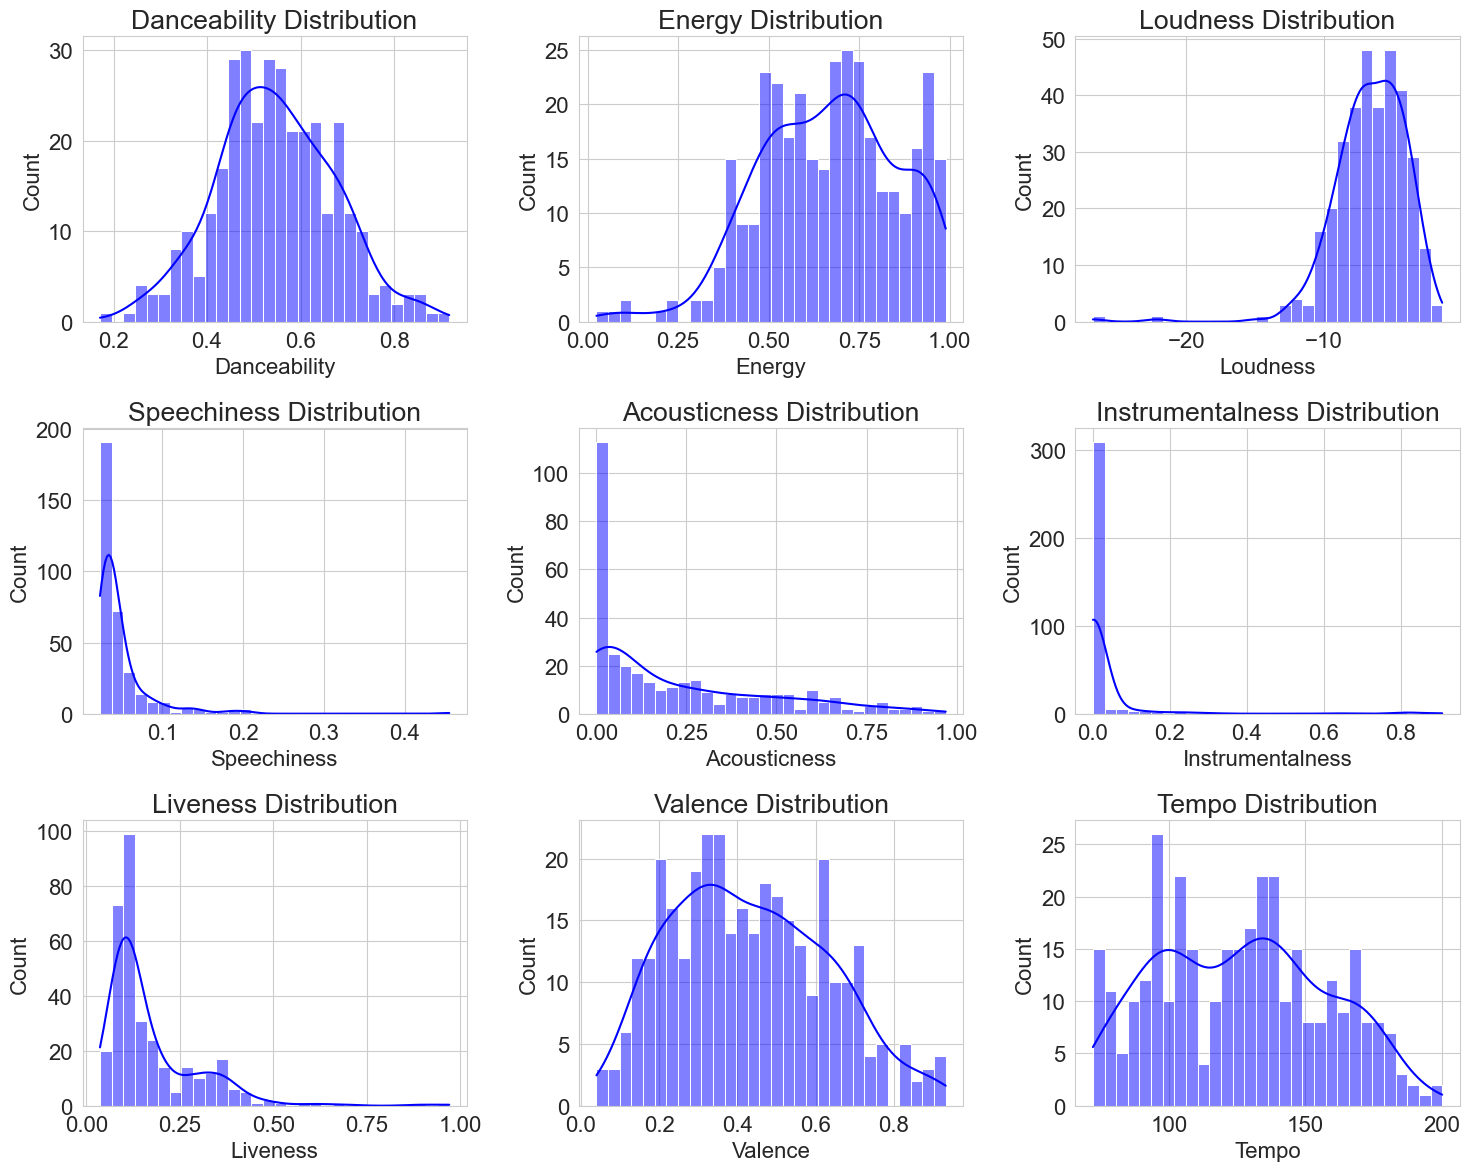

In [143]:
# Key– 一首歌曲共有多少種調性，可透過參數統計，例如 : 0 = C、1 = C♯/D♭、2 = D......以此類推，從中相加出一個總數。如果調性無法被偵測，則為負數 (即-1)。
# Mode– 稱作調式，可分為大調和小調。大調的參數是1，小調則是0。
# Acousticness– 一首歌曲的原聲樂器 (acoustic musical instrument) 所佔有比例。
# Danceability – 說明一首歌適合跳舞的程級，由各種音樂元素，如 : 音速 (tempo) 、韻律穩定性 (rhythm stability) 、拍子強度 (beat strength) 及整體密度 (overall regularity) 統算出來。
# Instrumentalness – 若越沒有人聲，樂器性便越強，其參數也就越高。一般上，參數在0.5以上會被歸類為純音樂。如果出現饒舌或口白，便可歸納成聲樂，而不是純音樂的曲目。
# Time Signature– 拍子記號的意思，表示一個小節有幾拍。
# Duration– 以毫秒（millisecond）作為單位，計算出一首歌的時長。
# Energy – 一首歌的能量，按照歌曲的強度和活力來判別。通常，高能量歌曲會聽起來比較快速、喧鬧和大聲。舉例來說，像死亡金屬之類的搖滾樂，會比巴哈的前奏曲來得強。另外，該首歌曲的動態程度（dynamic range）、響度感受（perceived loudness）、音色（timbre）、突發聲率（onset rate）及整體信號量（general entropy）也是其中主要的取決因素。
# Liveness– 如果偵測到觀眾聲音存在，便有可能是現場表演曲目。現場感越強，參數就越高。
# Loudness– 利用分貝計算出一首歌的整體響度。音樂振幅造成的主要心理關聯，將決定其響度。
# Speechiness– 某個曲目出現多少話語。越多便證明音檔越有可能屬於講座會、有聲書或詩歌朗讀。
# Valence– 一首歌曲的價態，即它帶來的正能量。價態越高，正能量便越多，聽起來就會是開心、快樂和愉悅。至於價態越低，負能量也相對低，讓人感覺悲傷、沮喪或憤怒。
# Tempo– 平均音速，由BPM計算出來，表示一分鐘內的拍子總數。BPM越高，節奏就越快。

import matplotlib.pyplot as plt
import seaborn as sns


audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(15, 12))
plt.rcParams['font.size'] = 16
sns.set_style('whitegrid')

for i, feature in enumerate(audio_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(total_feature_info_df[feature], kde=True, color='blue', bins=30)
    plt.title(f'{feature.capitalize()} Distribution')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

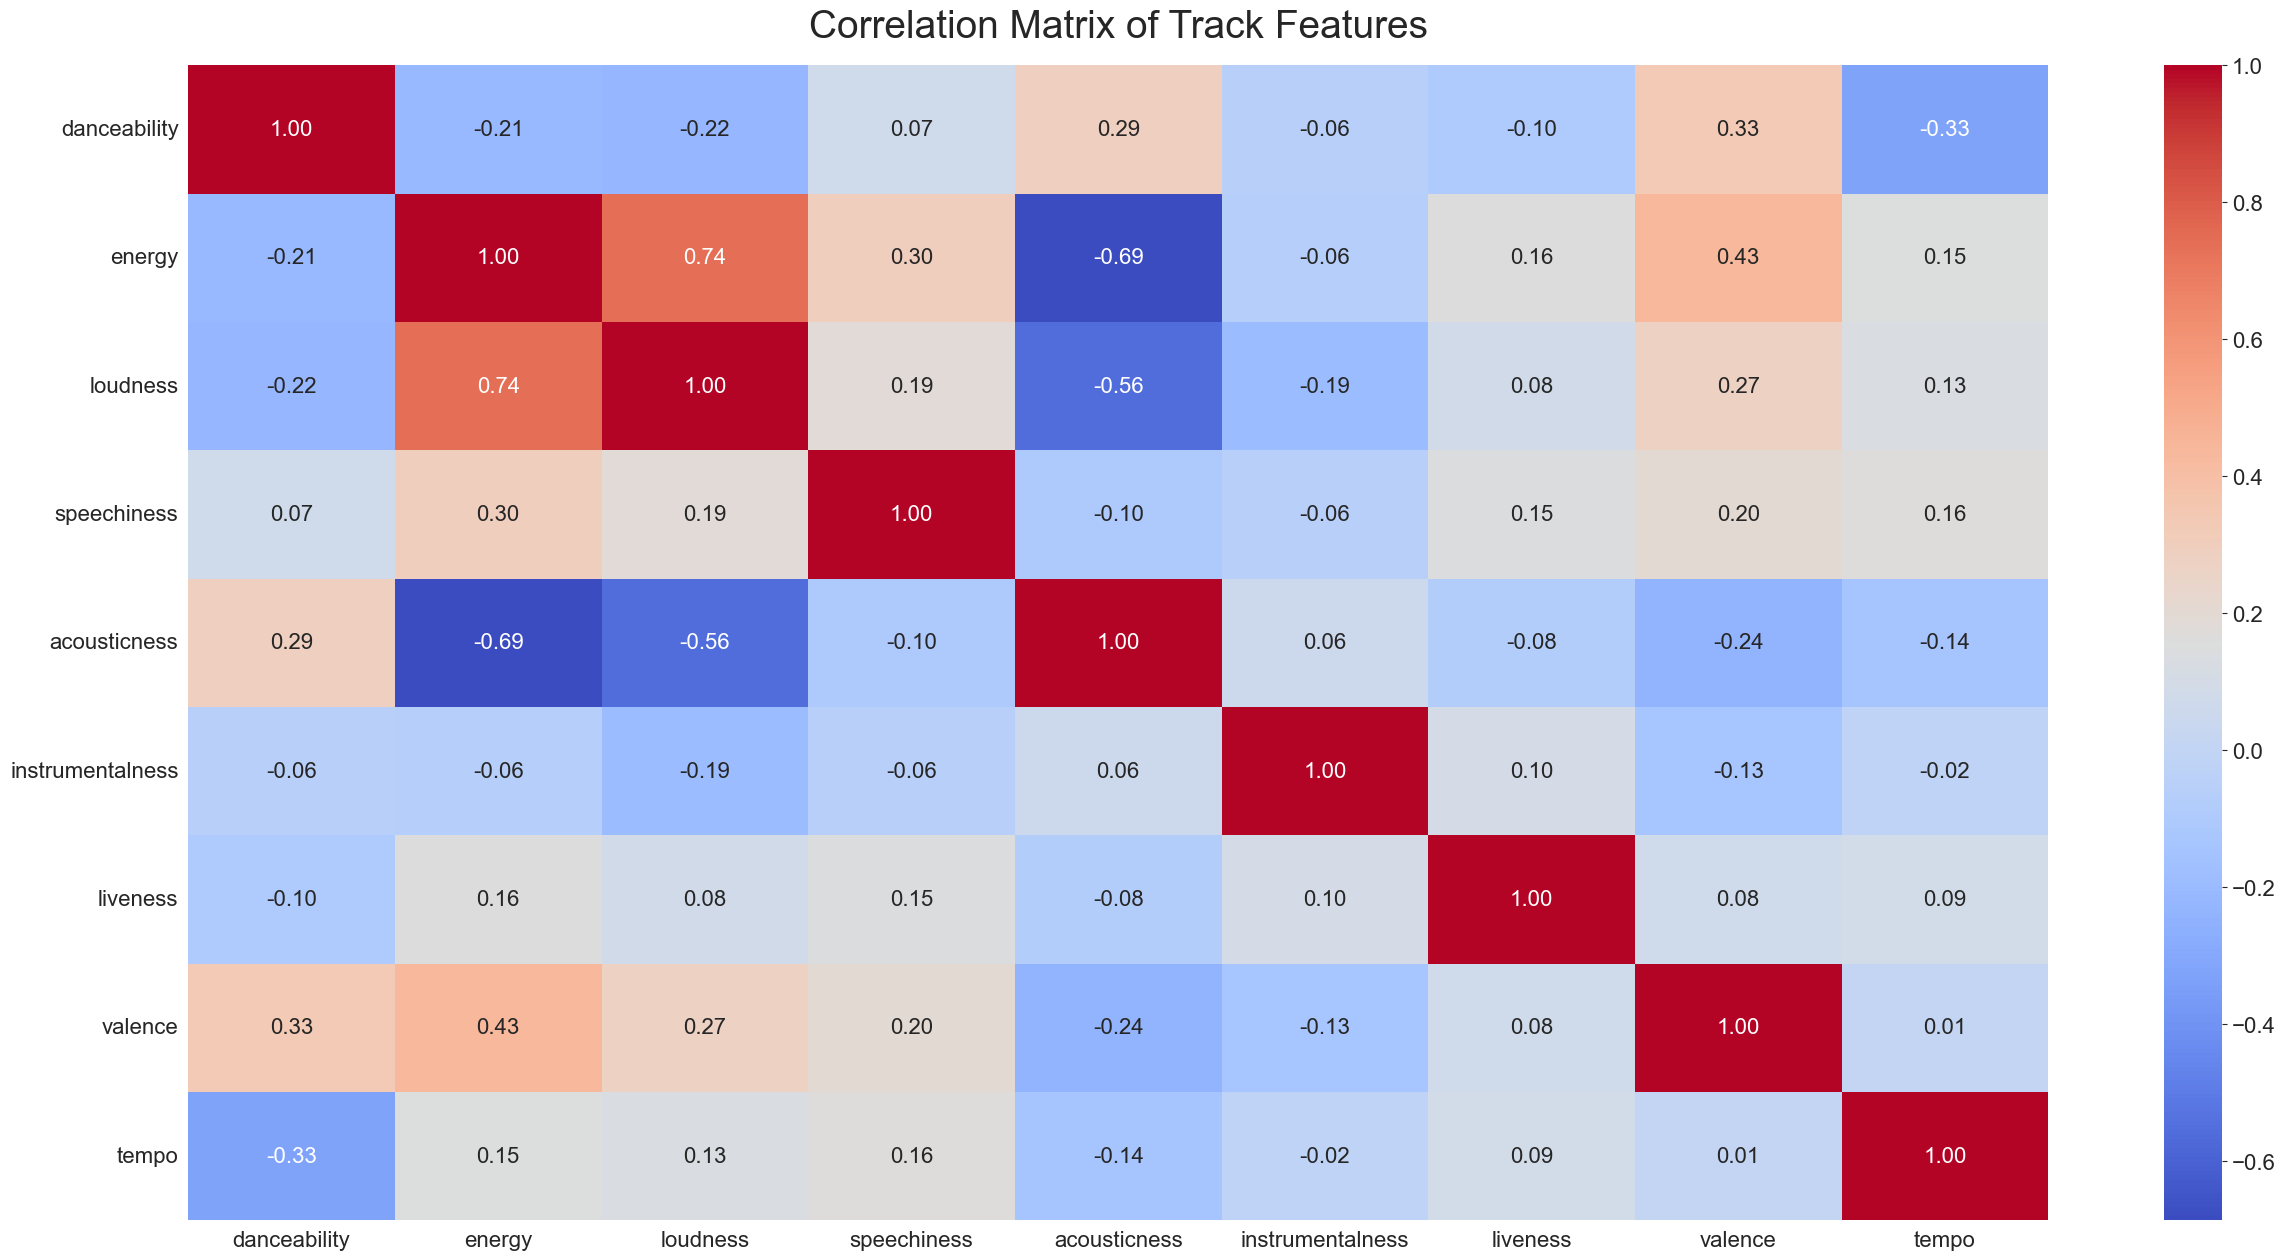

In [144]:
correlation_matrix = total_feature_info_df[audio_features].corr()

plt.figure(figsize=(30, 15))
plt.rcParams['font.size'] = 16
sns.set_style('whitegrid')
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
heatmap.set_title('Correlation Matrix of Track Features', fontsize=28, pad=20)
plt.show()

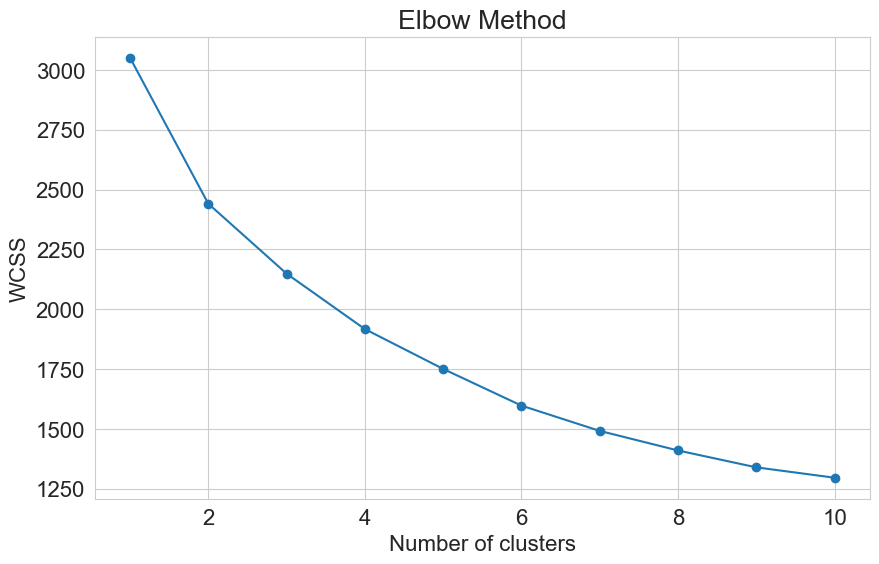

In [145]:
# from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


data_clustering = total_feature_info_df[audio_features]

scaler = StandardScaler()
data_clustering_scaled = scaler.fit_transform(data_clustering)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_clustering_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [146]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_clustering_scaled)
total_feature_info_df['cluster'] = clusters

In [147]:
# 群組 0
# 特點：適合跳舞的程度較低，音樂強度高，音量大，中等的自白話語和原聲性。
# 音樂風格：強烈且有節奏感的音樂，適合需要高能量背景音樂的場合，如運動或某些競賽活動。
# 群組 1
# 特點：適合跳舞的程度較高，音樂強度高，音量大，原聲性較明顯。
# 音樂風格：活力充沛且具有親和力的音樂，適合舞會和社交活動，能夠激發積極的情感和氛圍。
# 群組 2
# 特點：適合跳舞的程度中等，音樂強度非常高，自白話語相當多，極低的原聲性。
# 音樂風格：節奏快速且富有攻擊性的音樂，可能包括大量的電子元素和饒舌，適合現場表演和活力爆發的場合。
# 群組 3
# 特點：適合跳舞的程度中等，音樂強度低，音量小，非常高的原聲性和接近純音樂。(參數在0.5以上會被歸類為純音樂)
# 音樂風格：情緒深沉且具有藝術性的音樂，大量使用樂器鋪陳歌曲，適合安靜聆聽和反思，如咖啡廳背景音樂或獨自放鬆時聆聽。


columns = audio_features + ['cluster']
cluster_means = total_feature_info_df[columns].groupby('cluster').mean()
cluster_means

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.506946,0.739194,-5.602022,0.036162,0.083234,0.014790,0.130937,0.402706,106.691828
1,0.546240,0.469706,-8.839323,0.033815,0.462783,0.043356,0.155686,0.266683,132.194021
2,0.698812,0.636768,-7.114783,0.055514,0.273119,0.005261,0.192965,0.619072,108.933580
3,0.456827,0.842963,-4.618938,0.071389,0.047135,0.030044,0.224615,0.495877,157.674790


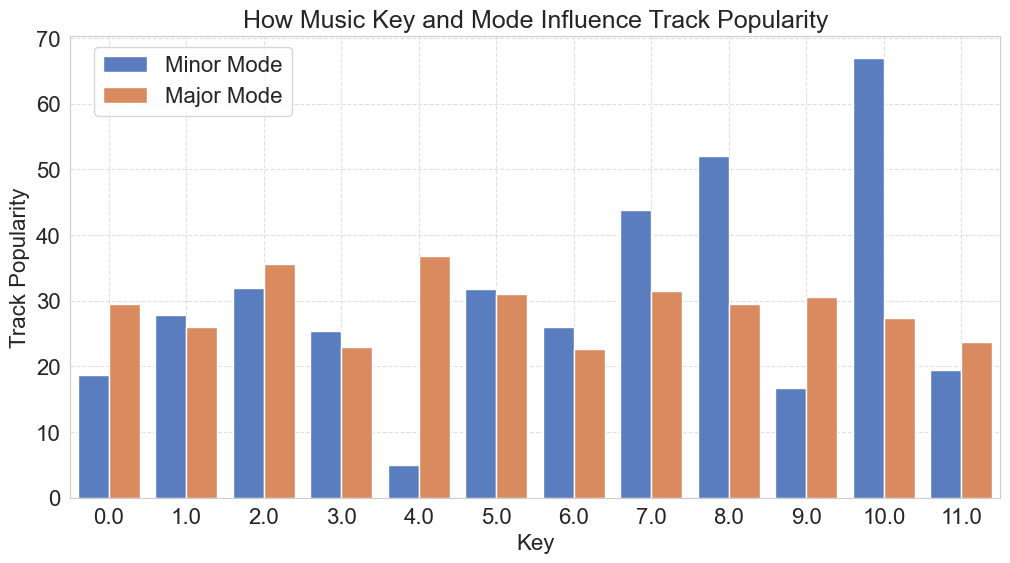

In [187]:
# 這張圖表顯示了不同音調和音調模式（0=小調, 1=大調）的曲目的平均流行度。
# 可以看到音調之間流行度的差異，其中某些調性的大調通常比小調更受歡迎，反之亦然。這可能與音調的情感表達有關，大調通常被認為更快樂和正面。

key_mode_grouped = total_feature_info_df.groupby(['key', 'mode']).agg({'danceability': 'mean', 'energy': 'mean', 'valence': 'mean', 'loudness': 'mean', 'track_popularity': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
plt.rcParams['font.size'] = 16

barplot = sns.barplot(data=key_mode_grouped, x='key', y='track_popularity', hue='mode', palette='muted')
plt.title('How Music Key and Mode Influence Track Popularity', fontsize=18)
plt.xlabel('Key')
plt.ylabel('Track Popularity')
handles, labels = barplot.get_legend_handles_labels()
plt.legend(handles, ['Minor Mode', 'Major Mode'], bbox_to_anchor=(0.25, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### 獲取藝人所有歌曲排名

In [188]:
# 滅火器
id = '7qBIgabdHdcr6NLujDxWAU'
country = 'TW'
api_link = f'https://api.spotify.com/v1/artists/{id}/top-tracks?market={country}'
headers = {'Authorization': 'Bearer ' + access_token}
res = requests.get(api_link, headers = headers).json()

In [189]:
df = pd.DataFrame()
for i in range(len(res['tracks'])):
  album = res['tracks'][i]['album']['name']
  song = res['tracks'][i]['name']
  popularity = res['tracks'][i]['popularity']
  result = pd.DataFrame({'album': [album], 'song': [song], 'popularity': [popularity]})
  df = pd.concat([df, result], ignore_index = True)

In [190]:
df = (df
      .sort_values(by = 'popularity', ascending = False)
      .reset_index()
      .drop('index', axis = 1))
df

,album,song,popularity
0,進擊下半場,長途夜車,52
1,Reborn,最後一個 - Acoustic,46
2,進擊下半場,島嶼天光,45
3,無名英雄,十二月的妳,45
4,進擊下半場,晚安台灣,44
5,家和萬事興,人生尾路,43
6,家和萬事興,家和萬事興,42
7,進擊下半場,海上的人,41
8,家和萬事興,人間條件,39
9,大嘻哈時代2: ROLL CALL 街頭支援,無名英雄 - 大嘻哈時代 Version,39
